# Testing some machine learning models

The purpose of this notebook is to test several machine learning models in our problem, trying to improve the TiC-Onco risk score results. 

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import pandas as pd
import numpy as np

# sklearn utils
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# sklearn models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier 
from sklearn.ensemble import GradientBoostingClassifier, VotingClassifier, StackingClassifier
from sklearn.tree import DecisionTreeClassifier

# SVM&I algorithm (LUSI)
from lusi import SVM_I

from utils import test_model, test_model_bootstrap

In [ ]:
SEED = 1997 # for reproducibility

In [ ]:
# reading data
path = 'data/'
data = pd.read_csv(path + 'data_TiC_Onco.csv')
X = data[data.columns.difference(['id','VTE','khorana'])]
y = data['VTE']
khorana = data['khorana']

X.shape, y.shape

((391, 9), (391,))

In [ ]:
X.head()

,Family,bmi,estadiGrup,rs2232698,rs4524,rs5985,rs6025,tipusTumor_HR,tipusTumor_VHR
0,0,1,1,0,1,1,0,0,0
1,0,0,0,0,1,0,0,0,1
2,0,0,1,0,2,0,0,1,0
3,0,0,1,0,2,0,0,0,0
4,0,1,1,0,2,0,0,0,0


In [ ]:
y.value_counts() 

0    318
1     73
Name: VTE, dtype: int64

### Baseline model (Logistic Regression)

In [ ]:
lr = LogisticRegression(solver='liblinear', random_state=SEED)

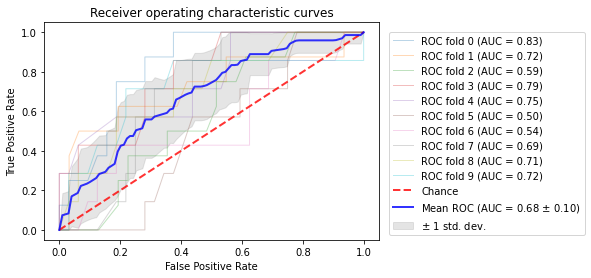

,score,mean,95% CI
0,AUC,0.68,"(0.48,0.89)"
1,accuracy,0.71,"(0.61,0.81)"
2,sensitivity,0.34,"(0,0.71)"
3,specificity,0.80,"(0.73,0.86)"
4,PPV,0.27,"(0.01,0.52)"
5,NPV,0.84,"(0.76,0.92)"


In [ ]:
test_model(lr, X, y)

## 1) Basic models for classification

### Logistic Regression

In [ ]:
lr = Pipeline([('LR',LogisticRegression(solver='liblinear', max_iter=10000, random_state=SEED))])

params_lr = {'LR__penalty': ['l1','l2'], 'LR__C': np.logspace(-4, 4, 50), 
          'LR__class_weight': [{1:0.5},{1:1},{1:5},{1:8},{1:10},{1:15},{1:20}]}


gs_lr = GridSearchCV(lr, params_lr, scoring='roc_auc', cv=10, n_jobs=2)
gs_lr.fit(X,y)
gs_lr.best_params_

{'LR__C': 0.0062505519252739694,
 'LR__class_weight': {1: 8},
 'LR__penalty': 'l2'}

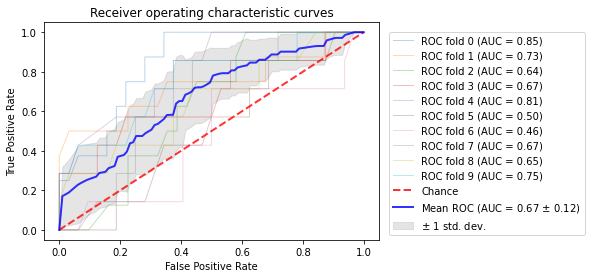

,score,mean,95% CI
0,AUC,0.67,"(0.44,0.91)"
1,accuracy,0.72,"(0.64,0.79)"
2,sensitivity,0.33,"(0,0.71)"
3,specificity,0.80,"(0.76,0.85)"
4,PPV,0.26,"(-0.0,0.52)"
5,NPV,0.84,"(0.76,0.92)"


In [ ]:
test_model(gs_lr.best_estimator_, X, y)

Adding MinMaxScaler:

In [ ]:
lr = Pipeline([('scaler',MinMaxScaler()), ('LR',LogisticRegression(solver='liblinear', max_iter=10000, random_state=SEED))])

params_lr = {'LR__penalty': ['l1','l2'], 'LR__C': np.logspace(-4, 4, 50), 
          'LR__class_weight': [{1:0.5},{1:1},{1:5},{1:8},{1:10},{1:15},{1:20}]}


gs_lr = GridSearchCV(lr, params_lr, scoring='roc_auc', cv=10, n_jobs=2)
gs_lr.fit(X,y)
gs_lr.best_params_

{'LR__C': 0.0020235896477251557,
 'LR__class_weight': {1: 10},
 'LR__penalty': 'l2'}

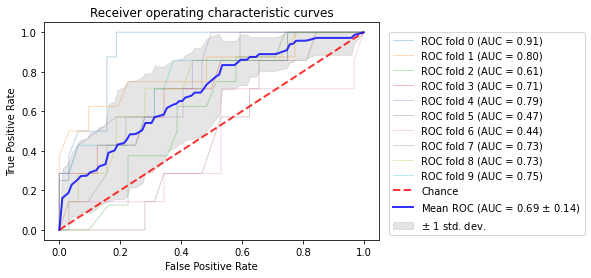

,score,mean,95% CI
0,AUC,0.69,"(0.42,0.97)"
1,accuracy,0.71,"(0.58,0.84)"
2,sensitivity,0.41,"(0,0.9)"
3,specificity,0.78,"(0.72,0.84)"
4,PPV,0.28,"(0,0.59)"
5,NPV,0.85,"(0.74,0.97)"


In [ ]:
test_model(gs_lr.best_estimator_, X, y)

### LinearSVC

Similar to SVC with parameter kernel=’linear’, but implemented in terms of liblinear, so it has more flexibility in the choice of penalties and loss functions.

In [ ]:
lin_svc = Pipeline([('scaler',MinMaxScaler()), ('LinearSVC',LinearSVC(random_state=SEED, max_iter=10000, dual=False))])

params_lin_svc = {'LinearSVC__penalty': ['l1','l2'], 'LinearSVC__C': np.logspace(-4, 4, 50), 
          'LinearSVC__class_weight': [{1:0.5},{1:1},{1:5},{1:8},{1:10},{1:15},{1:20}]}


gs_lin_svc = GridSearchCV(lin_svc, params_lin_svc, scoring='roc_auc', cv=10, n_jobs=2)
gs_lin_svc.fit(X,y)
gs_lin_svc.best_params_

{'LinearSVC__C': 0.00014563484775012445,
 'LinearSVC__class_weight': {1: 8},
 'LinearSVC__penalty': 'l2'}

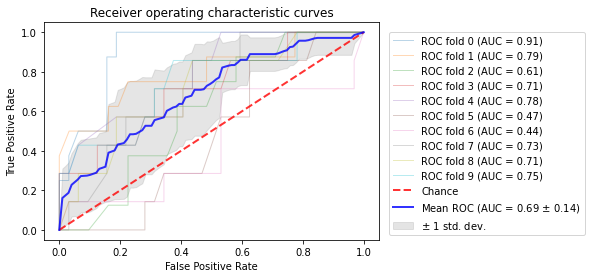

,score,mean,95% CI
0,AUC,0.69,"(0.42,0.97)"
1,accuracy,0.71,"(0.58,0.84)"
2,sensitivity,0.41,"(0,0.9)"
3,specificity,0.78,"(0.72,0.84)"
4,PPV,0.28,"(0,0.59)"
5,NPV,0.85,"(0.74,0.97)"


In [ ]:
test_model(gs_lin_svc.best_estimator_, X, y)

### KNN Classifier

In [ ]:
knn = Pipeline([('KNN',KNeighborsClassifier())])

params_knn = {'KNN__n_neighbors': np.linspace(3,299,num=75,dtype=int), 'KNN__weights': ['uniform','distance'], 
          'KNN__p': [1,2,3,4,5]}


gs_knn = GridSearchCV(knn, params_knn, scoring='roc_auc', cv=10, n_jobs=2)
gs_knn.fit(X,y)
gs_knn.best_params_

{'KNN__n_neighbors': 163, 'KNN__p': 1, 'KNN__weights': 'uniform'}

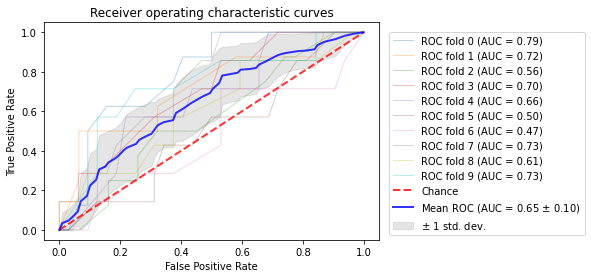

,score,mean,95% CI
0,AUC,0.65,"(0.44,0.85)"
1,accuracy,0.73,"(0.65,0.81)"
2,sensitivity,0.35,"(0.03,0.68)"
3,specificity,0.82,"(0.74,0.9)"
4,PPV,0.30,"(0.09,0.5)"
5,NPV,0.85,"(0.79,0.91)"


In [ ]:
test_model(gs_knn.best_estimator_, X, y)

Scaling data:

In [ ]:
knn = Pipeline([('scaler',MinMaxScaler()), ('KNN',KNeighborsClassifier())])

params_knn = {'KNN__n_neighbors': np.linspace(3,299,num=75,dtype=int), 'KNN__weights': ['uniform','distance'], 
          'KNN__p': [1,2,3,4,5]}


gs_knn = GridSearchCV(knn, params_knn, scoring='roc_auc', cv=10, n_jobs=2)
gs_knn.fit(X,y)
gs_knn.best_params_

{'KNN__n_neighbors': 219, 'KNN__p': 2, 'KNN__weights': 'uniform'}

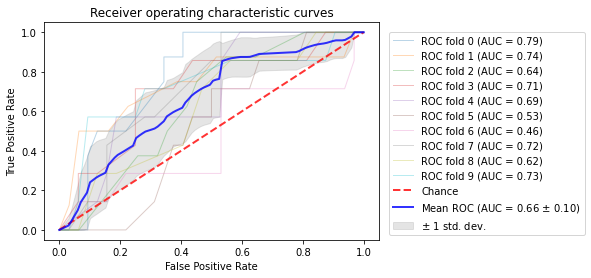

,score,mean,95% CI
0,AUC,0.66,"(0.47,0.86)"
1,accuracy,0.72,"(0.64,0.8)"
2,sensitivity,0.38,"(0,0.76)"
3,specificity,0.80,"(0.73,0.86)"
4,PPV,0.28,"(0.03,0.54)"
5,NPV,0.85,"(0.78,0.92)"


In [ ]:
test_model(gs_knn.best_estimator_, X, y)

### Support Vector Machine

In [ ]:
svc = Pipeline([('scaler',MinMaxScaler()), ('SVC',SVC(probability=True, random_state=SEED))])

params_svc = {'SVC__C': np.logspace(-4, 2, 10), 'SVC__kernel': ['poly','rbf'],
          'SVC__gamma': ['scale',0.1,1/9,0.15,0.2,0.3,0.4,0.5,0.6,0.8,1.0], 'SVC__class_weight': [{1:1},{1:5},{1:8},{1:10}]}


gs_svc = GridSearchCV(svc, params_svc, scoring='roc_auc', cv=10, n_jobs=2, verbose=2)
gs_svc.fit(X,y)
gs_svc.best_params_

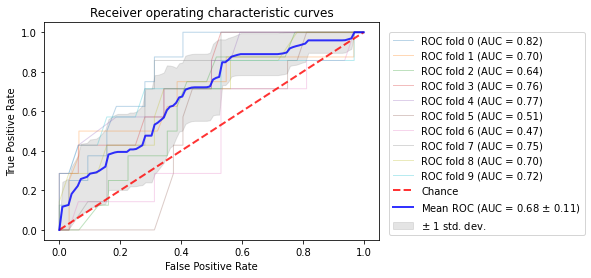

,score,mean,95% CI
0,AUC,0.68,"(0.47,0.9)"
1,accuracy,0.72,"(0.58,0.85)"
2,sensitivity,0.37,"(0,0.78)"
3,specificity,0.80,"(0.7,0.89)"
4,PPV,0.29,"(0,0.58)"
5,NPV,0.85,"(0.75,0.94)"


In [ ]:
test_model(gs_svc.best_estimator_, X, y)

## 2) Ensemble classifiers

### Bagging classifier

Using decision tree classifiers as base estimators:

In [ ]:
bagging = Pipeline([('Bagging',BaggingClassifier(random_state=SEED))])

params_bagging = {'Bagging__base_estimator': [DecisionTreeClassifier(random_state=SEED)], 
                  'Bagging__n_estimators': [5,10,15,20,25,30], 
                  'Bagging__max_samples': [0.5,0.6,0.7,0.8,0.9,1.0],
                  'Bagging__max_features': [0.2,0.3,0.5,0.8,1.0]}


gs_bagging = GridSearchCV(bagging, params_bagging, scoring='roc_auc', cv=10, n_jobs=2, verbose=1)
gs_bagging.fit(X,y)
gs_bagging.best_params_

Fitting 10 folds for each of 180 candidates, totalling 1800 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 122 tasks      | elapsed:    4.3s
[Parallel(n_jobs=2)]: Done 722 tasks      | elapsed:   20.2s
[Parallel(n_jobs=2)]: Done 1722 tasks      | elapsed:   47.5s
[Parallel(n_jobs=2)]: Done 1800 out of 1800 | elapsed:   50.0s finished


{'Bagging__base_estimator': DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                        max_depth=None, max_features=None, max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, presort='deprecated',
                        random_state=1997, splitter='best'),
 'Bagging__max_features': 0.2,
 'Bagging__max_samples': 0.9,
 'Bagging__n_estimators': 25}

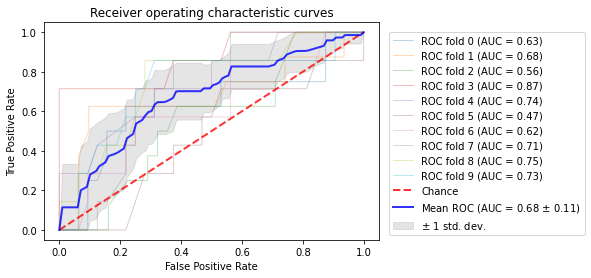

,score,mean,95% CI
0,AUC,0.68,"(0.46,0.89)"
1,accuracy,0.72,"(0.63,0.8)"
2,sensitivity,0.41,"(0.01,0.81)"
3,specificity,0.79,"(0.75,0.82)"
4,PPV,0.29,"(0.04,0.54)"
5,NPV,0.85,"(0.77,0.94)"


In [ ]:
test_model(gs_bagging.best_estimator_, X, y)

Using Logistic Regression as base estimator:

In [ ]:
base = gs_lr.best_estimator_
bagging = Pipeline([('scaler',MinMaxScaler()),('Bagging',BaggingClassifier(base_estimator=base, random_state=SEED))])

params_bagging = {'Bagging__n_estimators': [5,10,20,30,40,50], 
                  'Bagging__max_samples': [0.5,0.7,0.8,0.9,1.0],
                  'Bagging__max_features': [0.5,0.7,0.8,0.9,1.0]}


gs_bagging = GridSearchCV(bagging, params_bagging, scoring='roc_auc', cv=10, n_jobs=2, verbose=1)
gs_bagging.fit(X,y)
gs_bagging.best_params_

Fitting 10 folds for each of 150 candidates, totalling 1500 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 164 tasks      | elapsed:    7.9s
[Parallel(n_jobs=2)]: Done 764 tasks      | elapsed:   38.2s
[Parallel(n_jobs=2)]: Done 1500 out of 1500 | elapsed:  1.3min finished


{'Bagging__max_features': 0.7,
 'Bagging__max_samples': 0.7,
 'Bagging__n_estimators': 10}

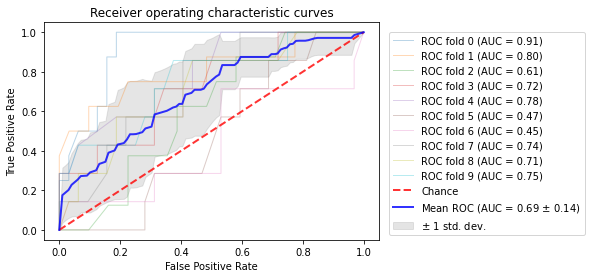

,score,mean,95% CI
0,AUC,0.69,"(0.42,0.97)"
1,accuracy,0.72,"(0.59,0.84)"
2,sensitivity,0.41,"(0,0.9)"
3,specificity,0.79,"(0.71,0.86)"
4,PPV,0.29,"(0,0.59)"
5,NPV,0.86,"(0.74,0.97)"


In [ ]:
test_model(gs_bagging.best_estimator_, X, y)

Using Linear SVC as base estimator: bad performance

Using best KNN as base estimator:

In [ ]:
base = gs_knn.best_estimator_
bagging = Pipeline([('scaler',MinMaxScaler()), ('Bagging',BaggingClassifier(base_estimator=base, random_state=SEED))])

params_bagging = {'Bagging__n_estimators': [5,10,20,30,40,50], 
                  'Bagging__max_samples': [0.5,0.7,0.8,0.9,1.0],
                  'Bagging__max_features': [0.5,0.7,0.8,0.9,1.0]}


gs_bagging = GridSearchCV(bagging, params_bagging, scoring='roc_auc', cv=10, n_jobs=2, verbose=1)
gs_bagging.fit(X,y)
gs_bagging.best_params_

Fitting 10 folds for each of 150 candidates, totalling 1500 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 164 tasks      | elapsed:   10.3s
[Parallel(n_jobs=2)]: Done 764 tasks      | elapsed:   53.9s
[Parallel(n_jobs=2)]: Done 1500 out of 1500 | elapsed:  1.8min finished


{'Bagging__max_features': 0.7,
 'Bagging__max_samples': 0.7,
 'Bagging__n_estimators': 10}

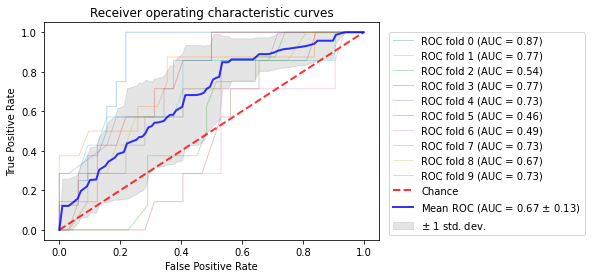

,score,mean,95% CI
0,AUC,0.68,"(0.42,0.93)"
1,accuracy,0.73,"(0.62,0.84)"
2,sensitivity,0.37,"(0,0.8)"
3,specificity,0.81,"(0.77,0.86)"
4,PPV,0.29,"(0,0.62)"
5,NPV,0.85,"(0.76,0.94)"


In [ ]:
test_model(gs_bagging.best_estimator_, X, y)

### Random Forest

In [ ]:
rf = Pipeline([('RF',RandomForestClassifier(random_state=SEED))])

params_rf = {'RF__n_estimators': [5,10,15,20,30,50], 'RF__max_depth': [None,2,3,5],
              'RF__max_features': ['sqrt',0.5,0.8], 'RF__max_samples': [0.5,0.8,1.0],
             'RF__class_weight': [{1:0.5},{1:1},{1:3},{1:5},{1:10}]}


gs_rf = GridSearchCV(rf, params_rf, scoring='roc_auc', cv=10, n_jobs=2, verbose=1)
gs_rf.fit(X,y)
gs_rf.best_params_

Fitting 10 folds for each of 1080 candidates, totalling 10800 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 300 tasks      | elapsed:    7.7s
[Parallel(n_jobs=2)]: Done 1500 tasks      | elapsed:   33.6s
[Parallel(n_jobs=2)]: Done 3500 tasks      | elapsed:  1.3min
[Parallel(n_jobs=2)]: Done 6300 tasks      | elapsed:  2.3min
[Parallel(n_jobs=2)]: Done 9900 tasks      | elapsed:  3.7min
[Parallel(n_jobs=2)]: Done 10800 out of 10800 | elapsed:  4.0min finished


{'RF__class_weight': {1: 3},
 'RF__max_depth': 3,
 'RF__max_features': 0.5,
 'RF__max_samples': 0.8,
 'RF__n_estimators': 5}

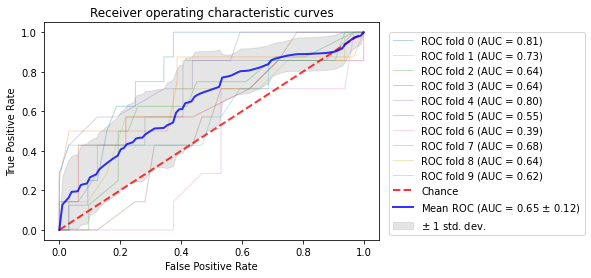

,score,mean,95% CI
0,AUC,0.65,"(0.41,0.88)"
1,accuracy,0.72,"(0.62,0.83)"
2,sensitivity,0.38,"(0,0.77)"
3,specificity,0.80,"(0.73,0.87)"
4,PPV,0.29,"(0.03,0.56)"
5,NPV,0.85,"(0.77,0.93)"


In [ ]:
test_model(gs_rf.best_estimator_, X, y)

### Extra Trees

In [ ]:
et = Pipeline([('ET',ExtraTreesClassifier(random_state=SEED))])

params_et = {'ET__n_estimators': [5,10,15,20,30,50], 'ET__max_depth': [None,2,3,5],
              'ET__max_features': ['sqrt',0.5,0.8],
             'ET__class_weight': [{1:0.5},{1:1},{1:3},{1:5},{1:10}]}


gs_et = GridSearchCV(et, params_et, scoring='roc_auc', cv=10, n_jobs=2, verbose=1)
gs_et.fit(X,y)
gs_et.best_params_

Fitting 10 folds for each of 360 candidates, totalling 3600 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 300 tasks      | elapsed:    8.1s
[Parallel(n_jobs=2)]: Done 1500 tasks      | elapsed:   39.9s
[Parallel(n_jobs=2)]: Done 3500 tasks      | elapsed:  1.5min
[Parallel(n_jobs=2)]: Done 3600 out of 3600 | elapsed:  1.6min finished


{'ET__class_weight': {1: 10},
 'ET__max_depth': 2,
 'ET__max_features': 'sqrt',
 'ET__n_estimators': 5}

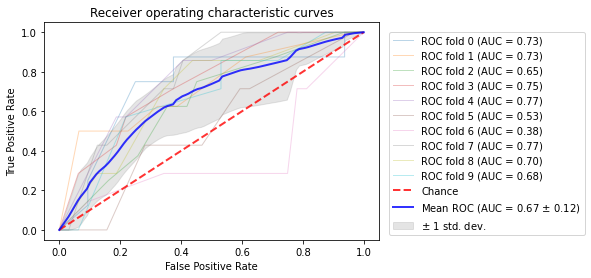

,score,mean,95% CI
0,AUC,0.67,"(0.43,0.91)"
1,accuracy,0.74,"(0.69,0.79)"
2,sensitivity,0.39,"(0,0.82)"
3,specificity,0.82,"(0.73,0.9)"
4,PPV,0.30,"(0.07,0.54)"
5,NPV,0.86,"(0.78,0.93)"


In [ ]:
test_model(gs_et.best_estimator_, X, y)

### AdaBoost

In [ ]:
ab = Pipeline([('AB',AdaBoostClassifier(random_state=SEED))])

params_ab = {'AB__n_estimators': [5,8,10,12,15,20,30,50,80,100],
              'AB__learning_rate': np.linspace(0.1, 2, num=20)}


gs_ab = GridSearchCV(ab, params_ab, scoring='roc_auc', cv=10, n_jobs=2, verbose=1)
gs_ab.fit(X,y)
gs_ab.best_params_

Fitting 10 folds for each of 200 candidates, totalling 2000 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 244 tasks      | elapsed:   10.2s
[Parallel(n_jobs=2)]: Done 836 tasks      | elapsed:   38.2s
[Parallel(n_jobs=2)]: Done 1836 tasks      | elapsed:  1.4min
[Parallel(n_jobs=2)]: Done 2000 out of 2000 | elapsed:  1.6min finished


{'AB__learning_rate': 1.5999999999999999, 'AB__n_estimators': 30}

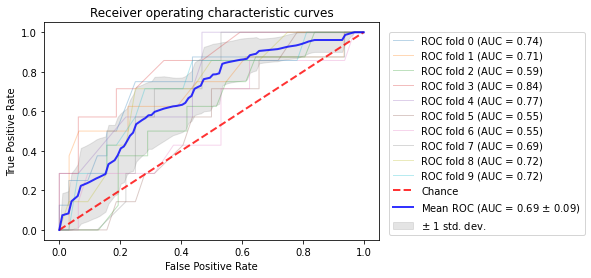

,score,mean,95% CI
0,AUC,0.69,"(0.51,0.87)"
1,accuracy,0.72,"(0.65,0.79)"
2,sensitivity,0.37,"(0.03,0.71)"
3,specificity,0.80,"(0.76,0.84)"
4,PPV,0.29,"(0.08,0.49)"
5,NPV,0.85,"(0.78,0.92)"


In [ ]:
test_model(gs_ab.best_estimator_, X, y)

### Gradient Boosting 

In [ ]:
gb = Pipeline([('GB',GradientBoostingClassifier(random_state=SEED))])

params_gb = {'GB__learning_rate': np.linspace(0.1, 2, num=20),
            'GB__n_estimators': [5,10,15,20,30,50], 
            'GB__max_features':['sqrt',0.5,0.8,1.0],
            'GB__subsample': [0.5,0.8,1.0], 'GB__max_depth': [2,3,5]}


gs_gb = GridSearchCV(gb, params_gb, scoring='roc_auc', cv=10, n_jobs=2, verbose=1)
gs_gb.fit(X,y)
gs_gb.best_params_

Fitting 10 folds for each of 4320 candidates, totalling 43200 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 540 tasks      | elapsed:    8.3s
[Parallel(n_jobs=2)]: Done 2184 tasks      | elapsed:   42.9s
[Parallel(n_jobs=2)]: Done 4168 tasks      | elapsed:  1.4min
[Parallel(n_jobs=2)]: Done 6968 tasks      | elapsed:  2.3min
[Parallel(n_jobs=2)]: Done 10568 tasks      | elapsed:  3.5min
[Parallel(n_jobs=2)]: Done 14968 tasks      | elapsed:  4.9min
[Parallel(n_jobs=2)]: Done 20168 tasks      | elapsed:  6.6min
[Parallel(n_jobs=2)]: Done 26168 tasks      | elapsed:  8.6min
[Parallel(n_jobs=2)]: Done 32968 tasks      | elapsed: 10.9min
[Parallel(n_jobs=2)]: Done 40568 tasks      | elapsed: 13.5min
[Parallel(n_jobs=2)]: Done 43200 out of 43200 | elapsed: 14.5min finished


{'GB__learning_rate': 0.2,
 'GB__max_depth': 2,
 'GB__max_features': 0.8,
 'GB__n_estimators': 15,
 'GB__subsample': 0.5}

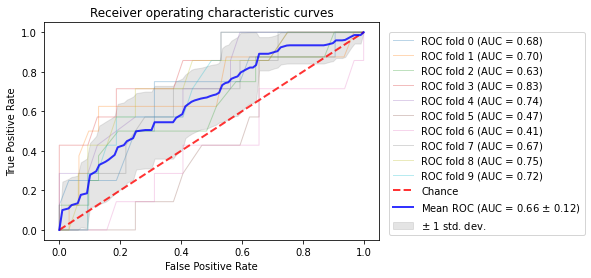

,score,mean,95% CI
0,AUC,0.66,"(0.41,0.9)"
1,accuracy,0.73,"(0.65,0.8)"
2,sensitivity,0.39,"(0,0.8)"
3,specificity,0.80,"(0.76,0.84)"
4,PPV,0.29,"(0.03,0.56)"
5,NPV,0.85,"(0.78,0.93)"


In [ ]:
test_model(gs_gb.best_estimator_, X, y)

### Voting Classifier

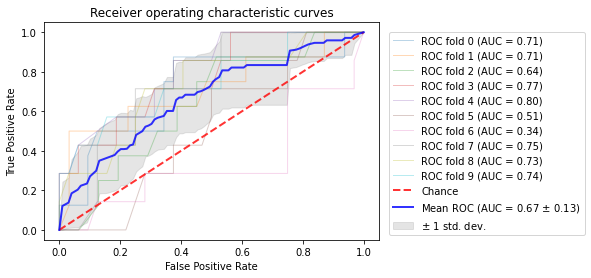

,score,mean,95% CI
0,AUC,0.67,"(0.4,0.94)"
1,accuracy,0.73,"(0.64,0.83)"
2,sensitivity,0.38,"(0.02,0.74)"
3,specificity,0.81,"(0.74,0.88)"
4,PPV,0.31,"(0.03,0.58)"
5,NPV,0.85,"(0.78,0.93)"


In [ ]:
estimators = [('lr',gs_lr.best_estimator_), ('knn',gs_knn.best_estimator_), ('et',gs_et.best_estimator_)]

voting = VotingClassifier(estimators=estimators, voting='soft')

test_model(voting, X, y)

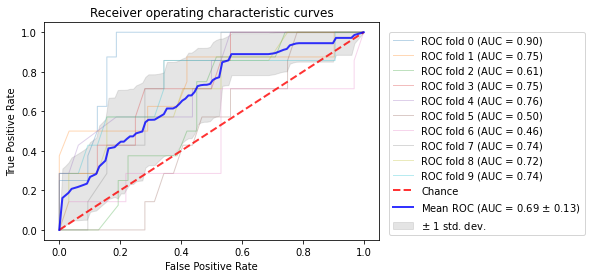

,score,mean,95% CI
0,AUC,0.69,"(0.44,0.94)"
1,accuracy,0.73,"(0.59,0.86)"
2,sensitivity,0.39,"(0,0.89)"
3,specificity,0.80,"(0.72,0.88)"
4,PPV,0.30,"(0,0.61)"
5,NPV,0.85,"(0.74,0.97)"


In [ ]:
estimators = [('lr',gs_lr.best_estimator_), ('knn',gs_knn.best_estimator_), ('bagging_lr',gs_bagging.best_estimator_)]

voting = Pipeline([('scaler',MinMaxScaler()), ('voting',VotingClassifier(estimators=estimators, voting='soft'))])

test_model(voting, X, y)

### Stacking Classifier

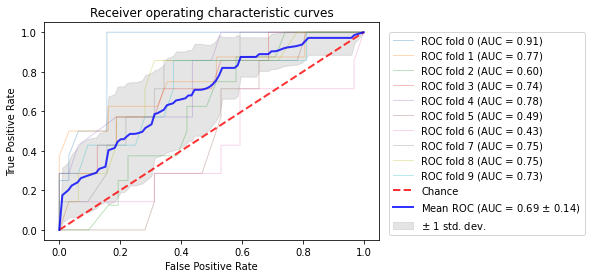

,score,mean,95% CI
0,AUC,0.69,"(0.42,0.97)"
1,accuracy,0.71,"(0.59,0.83)"
2,sensitivity,0.37,"(0,0.76)"
3,specificity,0.79,"(0.72,0.86)"
4,PPV,0.28,"(0,0.56)"
5,NPV,0.85,"(0.76,0.93)"


In [ ]:
estimators = [('linSVC',gs_lin_svc.best_estimator_), ('bagging_lr',gs_bagging.best_estimator_)]

stacking = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())
                              
test_model(stacking, X, y)

## 3) LUSI

### Basic predicates 

In [ ]:
# default predicates
svm_I = Pipeline([('scaler',MinMaxScaler()), ('SVM_I',SVM_I())])

params_svm_I = {'SVM_I__C': np.logspace(-4, 4, 40), 'SVM_I__kernel': ['linear','rbf'], 
          'SVM_I__gamma': [1, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 1/4, 1/5, 1/6, 1/8, 1/9, 1/10], 'SVM_I__pred_nn': [True, False]}


gs_svm_I = GridSearchCV(svm_I, params_svm_I, scoring='roc_auc', cv=10, n_jobs=2, verbose=2)
gs_svm_I.fit(X,y)
gs_svm_I.best_params_

Fitting 10 folds for each of 2080 candidates, totalling 20800 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    5.1s
[Parallel(n_jobs=2)]: Done 276 tasks      | elapsed:   17.7s
[Parallel(n_jobs=2)]: Done 682 tasks      | elapsed:   39.9s
[Parallel(n_jobs=2)]: Done 1248 tasks      | elapsed:  1.2min
[Parallel(n_jobs=2)]: Done 1978 tasks      | elapsed:  1.8min
[Parallel(n_jobs=2)]: Done 2868 tasks      | elapsed:  2.6min
[Parallel(n_jobs=2)]: Done 3922 tasks      | elapsed:  3.6min
[Parallel(n_jobs=2)]: Done 5136 tasks      | elapsed:  4.7min
[Parallel(n_jobs=2)]: Done 6514 tasks      | elapsed:  6.0min
[Parallel(n_jobs=2)]: Done 8052 tasks      | elapsed:  7.4min
[Parallel(n_jobs=2)]: Done 9754 tasks      | elapsed:  9.0min
[Parallel(n_jobs=2)]: Done 11616 tasks      | elapsed: 11.0min
[Parallel(n_jobs=2)]: Done 13642 tasks      | elapsed: 13.4min
[Parallel(n_jobs=2)]: Done 15828 tasks      | elapsed: 16.0min
[Parallel(n_jobs=2)]: Done 18178 tasks      | elapsed: 18

{'SVM_I__C': 942.6684551178854,
 'SVM_I__gamma': 0.6,
 'SVM_I__kernel': 'rbf',
 'SVM_I__pred_nn': True}

In [ ]:
gs_svm_I.best_estimator_[1].Phi.shape   # Phi matrix (number of predicates selected)

(8, 391)

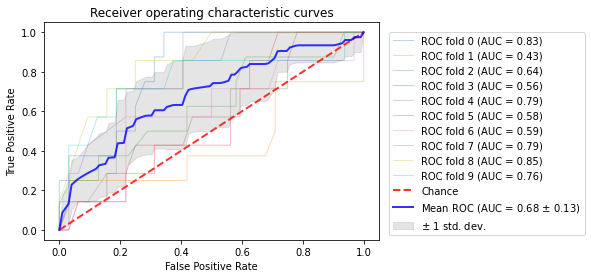

,score,mean,95% CI
0,AUC,0.68,"(0.41,0.95)"
1,accuracy,0.71,"(0.63,0.79)"
2,sensitivity,0.37,"(0.01,0.74)"
3,specificity,0.79,"(0.76,0.82)"
4,PPV,0.28,"(0.08,0.47)"
5,NPV,0.85,"(0.76,0.93)"


In [ ]:
test_model(gs_svm_I.best_estimator_, X, y)

### Custom predicates

In [ ]:
# using custom predicates (GRS == 0)
svm_I = Pipeline([('scaler',MinMaxScaler()), ('SVM_I',SVM_I())])

params_svm_I = {'SVM_I__C': np.logspace(-4, 4, 40), 'SVM_I__kernel': ['linear','rbf'], 
          'SVM_I__gamma': [1, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 1/4, 1/5, 1/6, 1/8, 1/9, 1/10], 'SVM_I__pred_nn': [True, False]}


gs_svm_I = GridSearchCV(svm_I, params_svm_I, scoring='roc_auc', cv=10, n_jobs=2, verbose=2)
gs_svm_I.fit(X,y)
gs_svm_I.best_params_

Fitting 10 folds for each of 2080 candidates, totalling 20800 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    5.1s
[Parallel(n_jobs=2)]: Done 276 tasks      | elapsed:   20.5s
[Parallel(n_jobs=2)]: Done 682 tasks      | elapsed:   46.9s
[Parallel(n_jobs=2)]: Done 1248 tasks      | elapsed:  1.4min
[Parallel(n_jobs=2)]: Done 1978 tasks      | elapsed:  2.2min
[Parallel(n_jobs=2)]: Done 2868 tasks      | elapsed:  3.2min
[Parallel(n_jobs=2)]: Done 3922 tasks      | elapsed:  4.3min
[Parallel(n_jobs=2)]: Done 5136 tasks      | elapsed:  5.6min
[Parallel(n_jobs=2)]: Done 6514 tasks      | elapsed:  7.2min
[Parallel(n_jobs=2)]: Done 8052 tasks      | elapsed:  8.9min
[Parallel(n_jobs=2)]: Done 9754 tasks      | elapsed: 10.9min
[Parallel(n_jobs=2)]: Done 11616 tasks      | elapsed: 13.2min
[Parallel(n_jobs=2)]: Done 13642 tasks      | elapsed: 15.8min
[Parallel(n_jobs=2)]: Done 15828 tasks      | elapsed: 18.7min
[Parallel(n_jobs=2)]: Done 18178 tasks      | elapsed: 21

{'SVM_I__C': 55.41020330009492,
 'SVM_I__gamma': 0.5,
 'SVM_I__kernel': 'rbf',
 'SVM_I__pred_nn': True}

In [ ]:
gs_svm_I.best_estimator_[1].Phi.shape   # Phi matrix (number of predicates selected)

(10, 352)

/content/lusi.py:214: RuntimeWarning: divide by zero encountered in double_scalars
  T.append(abs(num) / den)
/content/lusi.py:214: RuntimeWarning: divide by zero encountered in double_scalars
  T.append(abs(num) / den)
/content/lusi.py:214: RuntimeWarning: divide by zero encountered in double_scalars
  T.append(abs(num) / den)
/content/lusi.py:214: RuntimeWarning: divide by zero encountered in double_scalars
  T.append(abs(num) / den)
/content/lusi.py:214: RuntimeWarning: divide by zero encountered in double_scalars
  T.append(abs(num) / den)
/content/lusi.py:214: RuntimeWarning: divide by zero encountered in double_scalars
  T.append(abs(num) / den)
/content/lusi.py:214: RuntimeWarning: divide by zero encountered in double_scalars
  T.append(abs(num) / den)
/content/lusi.py:214: RuntimeWarning: divide by zero encountered in double_scalars
  T.append(abs(num) / den)
/content/lusi.py:214: RuntimeWarning: divide by zero encountered in double_scalars
  T.append(abs(num) / den)
/content/l

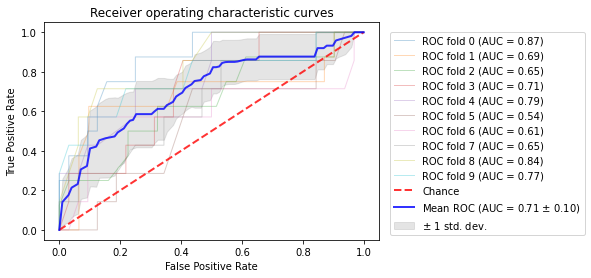

,score,mean,95% CI
0,AUC,0.71,"(0.51,0.91)"
1,accuracy,0.74,"(0.66,0.82)"
2,sensitivity,0.49,"(0.1,0.88)"
3,specificity,0.80,"(0.74,0.85)"
4,PPV,0.34,"(0.12,0.56)"
5,NPV,0.87,"(0.79,0.95)"


In [ ]:
test_model(gs_svm_I.best_estimator_, X, y)

In [ ]:
# using custom predicates (GRS & p-value == 0)
svm_I = Pipeline([('scaler',MinMaxScaler()), ('SVM_I',SVM_I())])

params_svm_I = {'SVM_I__C': np.logspace(-4, 4, 40), 'SVM_I__kernel': ['linear','rbf'], 
          'SVM_I__gamma': [1, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 1/4, 1/5, 1/6, 1/8, 1/9, 1/10], 'SVM_I__pred_nn': [True, False]}


gs_svm_I = GridSearchCV(svm_I, params_svm_I, scoring='roc_auc', cv=10, n_jobs=2, verbose=1)
gs_svm_I.fit(X,y)
gs_svm_I.best_params_

Fitting 10 folds for each of 2080 candidates, totalling 20800 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  62 tasks      | elapsed:    6.7s
[Parallel(n_jobs=2)]: Done 662 tasks      | elapsed:   43.4s
[Parallel(n_jobs=2)]: Done 1662 tasks      | elapsed:  1.7min
[Parallel(n_jobs=2)]: Done 3062 tasks      | elapsed:  3.2min
[Parallel(n_jobs=2)]: Done 4862 tasks      | elapsed:  5.1min
[Parallel(n_jobs=2)]: Done 7062 tasks      | elapsed:  7.4min
[Parallel(n_jobs=2)]: Done 9662 tasks      | elapsed: 10.3min
[Parallel(n_jobs=2)]: Done 12662 tasks      | elapsed: 14.0min
[Parallel(n_jobs=2)]: Done 16062 tasks      | elapsed: 18.3min
[Parallel(n_jobs=2)]: Done 19862 tasks      | elapsed: 23.2min
[Parallel(n_jobs=2)]: Done 20800 out of 20800 | elapsed: 24.4min finished
/content/lusi.py:214: RuntimeWarning: divide by zero encountered in double_scalars
  while T_max > self.delta and len(predicates) > 0:


{'SVM_I__C': 942.6684551178854,
 'SVM_I__gamma': 0.5,
 'SVM_I__kernel': 'rbf',
 'SVM_I__pred_nn': True}

/content/lusi.py:214: RuntimeWarning: divide by zero encountered in double_scalars
  while T_max > self.delta and len(predicates) > 0:
/content/lusi.py:214: RuntimeWarning: divide by zero encountered in double_scalars
  while T_max > self.delta and len(predicates) > 0:
/content/lusi.py:214: RuntimeWarning: divide by zero encountered in double_scalars
  while T_max > self.delta and len(predicates) > 0:
/content/lusi.py:214: RuntimeWarning: divide by zero encountered in double_scalars
  while T_max > self.delta and len(predicates) > 0:
/content/lusi.py:214: RuntimeWarning: divide by zero encountered in double_scalars
  while T_max > self.delta and len(predicates) > 0:
/content/lusi.py:214: RuntimeWarning: divide by zero encountered in double_scalars
  while T_max > self.delta and len(predicates) > 0:
/content/lusi.py:214: RuntimeWarning: divide by zero encountered in double_scalars
  while T_max > self.delta and len(predicates) > 0:
/content/lusi.py:214: RuntimeWarning: divide by zero en

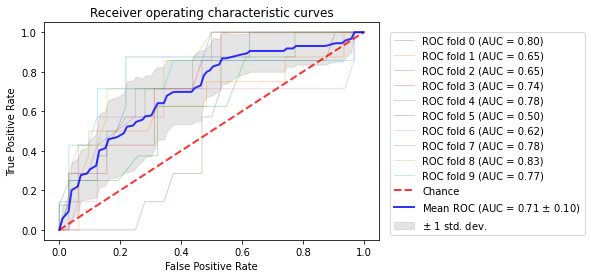

,score,mean,95% CI
0,AUC,0.71,"(0.52,0.91)"
1,accuracy,0.73,"(0.64,0.82)"
2,sensitivity,0.45,"(0.05,0.86)"
3,specificity,0.80,"(0.73,0.86)"
4,PPV,0.33,"(0.08,0.57)"
5,NPV,0.87,"(0.78,0.95)"


In [ ]:
test_model(gs_svm_I.best_estimator_, X, y)

In [ ]:
# low>0 & GRS==0

svm_I = Pipeline([('scaler',MinMaxScaler()), ('SVM_I',SVM_I())])

params_svm_I = {'SVM_I__C': np.logspace(-4, 4, 40), 'SVM_I__kernel': ['linear','rbf'], 
          'SVM_I__gamma': [1, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 1/4, 1/5, 1/6, 1/8, 1/9, 1/10], 'SVM_I__pred_nn': [True, False]}


gs_svm_I = GridSearchCV(svm_I, params_svm_I, scoring='roc_auc', cv=10, n_jobs=2, verbose=2)
gs_svm_I.fit(X,y)
gs_svm_I.best_params_

Fitting 10 folds for each of 2080 candidates, totalling 20800 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    3.0s
[Parallel(n_jobs=2)]: Done 276 tasks      | elapsed:   19.9s
[Parallel(n_jobs=2)]: Done 682 tasks      | elapsed:   49.2s
[Parallel(n_jobs=2)]: Done 1248 tasks      | elapsed:  1.5min
[Parallel(n_jobs=2)]: Done 1978 tasks      | elapsed:  2.4min
[Parallel(n_jobs=2)]: Done 2868 tasks      | elapsed:  3.4min
[Parallel(n_jobs=2)]: Done 3922 tasks      | elapsed:  4.7min
[Parallel(n_jobs=2)]: Done 5136 tasks      | elapsed:  6.1min
[Parallel(n_jobs=2)]: Done 6514 tasks      | elapsed:  7.8min
[Parallel(n_jobs=2)]: Done 8052 tasks      | elapsed:  9.8min
[Parallel(n_jobs=2)]: Done 9754 tasks      | elapsed: 12.0min
[Parallel(n_jobs=2)]: Done 11616 tasks      | elapsed: 14.6min
[Parallel(n_jobs=2)]: Done 13642 tasks      | elapsed: 17.6min
[Parallel(n_jobs=2)]: Done 15828 tasks      | elapsed: 20.8min
[Parallel(n_jobs=2)]: Done 18178 tasks      | elapsed: 24

{'SVM_I__C': 2424.462017082326,
 'SVM_I__gamma': 0.5,
 'SVM_I__kernel': 'rbf',
 'SVM_I__pred_nn': True}

/content/lusi.py:214: RuntimeWarning: divide by zero encountered in double_scalars
  
/content/lusi.py:214: RuntimeWarning: divide by zero encountered in double_scalars
  
/content/lusi.py:214: RuntimeWarning: divide by zero encountered in double_scalars
  
/content/lusi.py:214: RuntimeWarning: divide by zero encountered in double_scalars
  
/content/lusi.py:214: RuntimeWarning: divide by zero encountered in double_scalars
  
/content/lusi.py:214: RuntimeWarning: divide by zero encountered in double_scalars
  
/content/lusi.py:214: RuntimeWarning: divide by zero encountered in double_scalars
  
/content/lusi.py:214: RuntimeWarning: divide by zero encountered in double_scalars
  
/content/lusi.py:214: RuntimeWarning: divide by zero encountered in double_scalars
  
/content/lusi.py:214: RuntimeWarning: divide by zero encountered in double_scalars
  


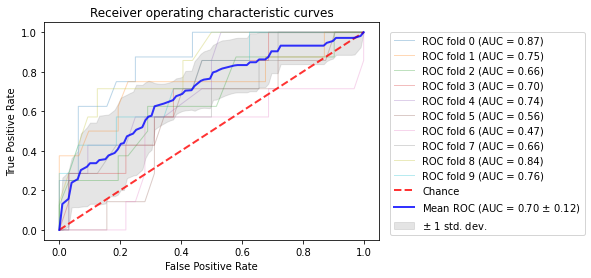

,score,mean,95% CI
0,AUC,0.70,"(0.47,0.93)"
1,accuracy,0.73,"(0.64,0.82)"
2,sensitivity,0.38,"(0,0.86)"
3,specificity,0.81,"(0.78,0.84)"
4,PPV,0.29,"(0,0.61)"
5,NPV,0.85,"(0.76,0.95)"


In [ ]:
test_model(gs_svm_I.best_estimator_, X, y)